In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.stats import linregress
import random
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib.lines import Line2D


In [2]:
tl_df = pd.read_csv('../raw_data/tl_norm_data_2.txt', delimiter='\t', index_col=0)

In [3]:
def get_sample_info(sample_name):
    """Get sample name, experiment, and replicate number."""
    smpl, expmt, rep = sample_name.split('_')
    return(smpl, expmt, rep)

def get_timepoints(tl_data):
    """Get timepoints for given experimental data."""
    tl_df_cols = np.array([0, 10, 20, 25, 30, 40, 50, 55, 60, 70])
    nanmask = np.isnan(tl_data)
    sample_timepoints = tl_df_cols[~nanmask]
    
    return(sample_timepoints, tl_data[~nanmask])

In [4]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def fit_monoExp(xs, ys, name):
    print(name)
    
    # perform the fit
    p0 = (1, 0.1, 0) # start with values near those we expect
    params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
    m, t, b = params
    sampleRate = 20_000 # Hz
    tauSec = (1 / t) / sampleRate

    # determine quality of the fit
    squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    halflife = (np.log((0.5 - b) / m) / (-t))

    return(m, t, b, rSquared)

In [5]:
halflife_arr = []
rsquared_arr = []
for sample in tl_df.index.tolist():
    tl_data = tl_df.loc[sample].values
    
    smpl, expt, rep = get_sample_info(sample)
    timepoints, tl_vals = get_timepoints(tl_data)
    
    m, t, b, rsquared = fit_monoExp(timepoints, tl_vals, smpl)
    
    halflife = (np.log((0.5 - b) / m) / (-t))
    
    halflife_arr.append(halflife)
    rsquared_arr.append(rsquared)

tl_df['half life'] = halflife_arr
tl_df['rsquared'] = rsquared_arr

c-Src
W285T
E283D
c-Src
c-Src
c-Src
F512P
F512P
F512P
W285C
W285C
W285C
c-Src
c-Src
F512P
F512P
W285C
W285C
W285T
W285T
W285T
E283D
E283D
E283D
c-Src
c-Src
c-Src
F512A
F512A
F512A
E508F
E508F
E508F
G287S
G287S
G287S
E273T
E273T
E273T


In [6]:
# Get averages half-lives for each rep
"""
    Get the sample and experiment
    Find any other samples in the DF that are the same sample and experiment
    Calculate the average
    Add average to a list
    Add sample_expt to list
"""

ave_hl_arr = []
err_hl_arr = []
smpl_expt_arr = []

tl_df_idx = tl_df.index.tolist()



for sample in tl_df_idx:
    # Get the sample and experment
    smpl_expt = sample[:-2]
    
    # Continue if smpl_expt already recorded
    if smpl_expt in smpl_expt_arr:
        continue
    
    # Find any other samples in the DF that are the same sample and experiment
    replicate_mask = [smpl_expt in smpl_name for smpl_name in tl_df_idx]
    replicate_mask[tl_df_idx.index('c-Src_0709_2')] = False
    replicate_mask[tl_df_idx.index('W285C_0805_2')] = False
    rep_df = tl_df[replicate_mask]['half life']
    
    # Calculate the average half-life
    ave_hl = rep_df.mean()
    err_hl = rep_df.std()
    
    # Add average and experiment to list
    ave_hl_arr.append(ave_hl)
    err_hl_arr.append(err_hl)
    smpl_expt_arr.append(smpl_expt)

In [7]:
# Get half-life of each replicate relative to c-Src for that experiment

# Get list of unique experiments
unq_exp_list = []
for sample in tl_df.index.tolist():
    exp_id = get_sample_info(sample)[1]
    if exp_id not in unq_exp_list:
        unq_exp_list.append(exp_id)
        
# Average c-Src half-lives (if available)
wt_hl_list = []
for exp_id in unq_exp_list:
    exp_idx = [exp_id in sample for sample in tl_df.index.tolist()]
    exp_df = tl_df[exp_idx]
    wt_idx = ['c-Src' in sample for sample in exp_df.index.tolist()]
    wt_ave_hl = exp_df[wt_idx]['half life'].mean()
    wt_hl_list.append(wt_ave_hl)
wt_hl_dict = dict(zip(unq_exp_list, wt_hl_list))

# Calculate half-life relative to average c-Src half-life of experiment
rel_hl_list = []
for sample in tl_df.index.tolist():
    sample_id, exp_id, rep_id = get_sample_info(sample)
    ave_wt_hl = wt_hl_dict[exp_id]
    if 'c-Src' in sample:
        rel_hl_list.append(ave_wt_hl)
    elif 'W285C_0805_2' in sample:
        rel_hl_list.append(np.nan)
    else:
        rel_hl = tl_df.loc[sample]['half life'] / ave_wt_hl
        rel_hl_list.append(rel_hl)
tl_df['rel half life'] = rel_hl_list


In [8]:
# Average variants and plot
sample_list = []
for sample in tl_df.index.tolist():
    sample_id, _, _ = get_sample_info(sample)
    if sample_id not in sample_list:
        sample_list.append(sample_id)
        
# Initiating these lists with c-Src values 1,0
total_ave_hl = [1]
total_std_hl = [0]
for sample in sample_list[1:]:
    
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    total_ave_hl.append(sample_hls.mean())
    total_std_hl.append(sample_hls.std())
    
xarr = np.arange(len(sample_list))

In [9]:
# Plot the individual plots as DF suggested
# Get the array of relative half-lives and add randomizer between 0 and 0.5
sample_hl_dict = {}
for sample, xpos in zip(sample_list[1:3], xarr[1:3]):
    
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    if 'W285T' in sample:
        sample_hl_dict['W285T'] = sample_hls
    if 'E283D' in sample:
        sample_hl_dict['E283D'] = sample_hls
    n = len(sample_hls)
    
    x_jitter_pos = np.array([xpos] * n)
    rand_arr = (np.random.rand(n) - 0.5) / 5 
    x_jitter_pos = x_jitter_pos + rand_arr
    


# statistical annotation
t, p = scipy.stats.ttest_ind(sample_hl_dict['W285T'], sample_hl_dict['E283D'])
x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 1.6 + 0.1, 0.1, 'k'


In [10]:
# Try normalizing to c-Src
"""
    Get sample name and experiment number
    Normalize to c-Src (variant over c-Src), so c-Src should be one
    !!! How do I compare the errors !!!
    Average each variant across experiments
        Get sample name
        Get all other instances of that sample
        Calculate average and std
        Plot
"""
norm_hl_arr = []
for smpl_id, ave_hl in zip(smpl_expt_arr, ave_hl_arr):
    # Get sample name and experiment number
    expt = smpl_id[-4:]
    
    # Normalize to c-Src so that c-Src HL = 1
    wt_idx = smpl_expt_arr.index('c-Src_' + expt)
    wt_hl = ave_hl_arr[wt_idx]
    norm_hl = ave_hl / wt_hl
    norm_hl_arr.append(norm_hl)

    
# Average each variant across experiments
norm_smpl_ave_arr = []
norm_smpl_std_arr = []
norm_smpl_arr = []
for smpl_id in smpl_expt_arr:
    # Get sample name
    smpl_name = smpl_id[:-5]
    
    # Skip if already recorded
    if smpl_name in norm_smpl_arr:
        continue
    
    # Get all other instances of that sample
    smpl_mask = [smpl_name in smpl_expt for smpl_expt in smpl_expt_arr]
    smpl_norm_hl_arr = np.array(norm_hl_arr)[smpl_mask]
    
    # Calculate average and std
    norm_smpl_ave = np.mean(smpl_norm_hl_arr)
    norm_smpl_std = np.std(smpl_norm_hl_arr)
    
    # Record average, std, and name
    norm_smpl_ave_arr.append(norm_smpl_ave)
    norm_smpl_std_arr.append(norm_smpl_std)
    norm_smpl_arr.append(smpl_name)
    
color_arr = ['lightblue', 'coral', 'lightpink', 'lightgreen', 'deepskyblue', 'lightgreen', 'lightgreen', 'deepskyblue', 'deepskyblue']

In [11]:
test_vars = [
    'c-Src',
    'F512P',
    'W285C',
    'W285T',
    'E283D',
    'W285M',
    'E381S',
    'F512A',
    'E508F',
    'G287S',
    'E273T'
]

diffsel_df = pd.read_csv('../utils/diffsel_calib.csv', index_col=0)
dmso_df = pd.read_csv('../utils/point_muts_calib.csv', index_col=0, header=[0,1])
dmso_df.rename(dict(zip(dmso_df.index.tolist(), diffsel_df.index.tolist())), inplace=True)

test_var_act = []
test_var_client = []

for variant in test_vars:
    if variant == 'c-Src':
        variant = '_wt'
    test_var_act.append(dmso_df.loc[variant, ('Zero', 'score')])
    test_var_client.append(diffsel_df.loc[variant, 'diffsel'])
    
test_var_df = pd.DataFrame([test_vars, test_var_act, test_var_client]).T
test_var_df.rename(dict(zip(test_var_df.columns.tolist(), ['sample', 'activity score', 'client score'])), axis=1, inplace=True)
test_var_df.set_index('sample', inplace=True)

act_arr = test_var_df.loc[norm_smpl_arr]['activity score'].values
client_arr = test_var_df.loc[norm_smpl_arr]['client score'].values
norm_smpl_ave_arr = np.array(norm_smpl_ave_arr).astype(float)

In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

perc_axes = 0.07409181787428054


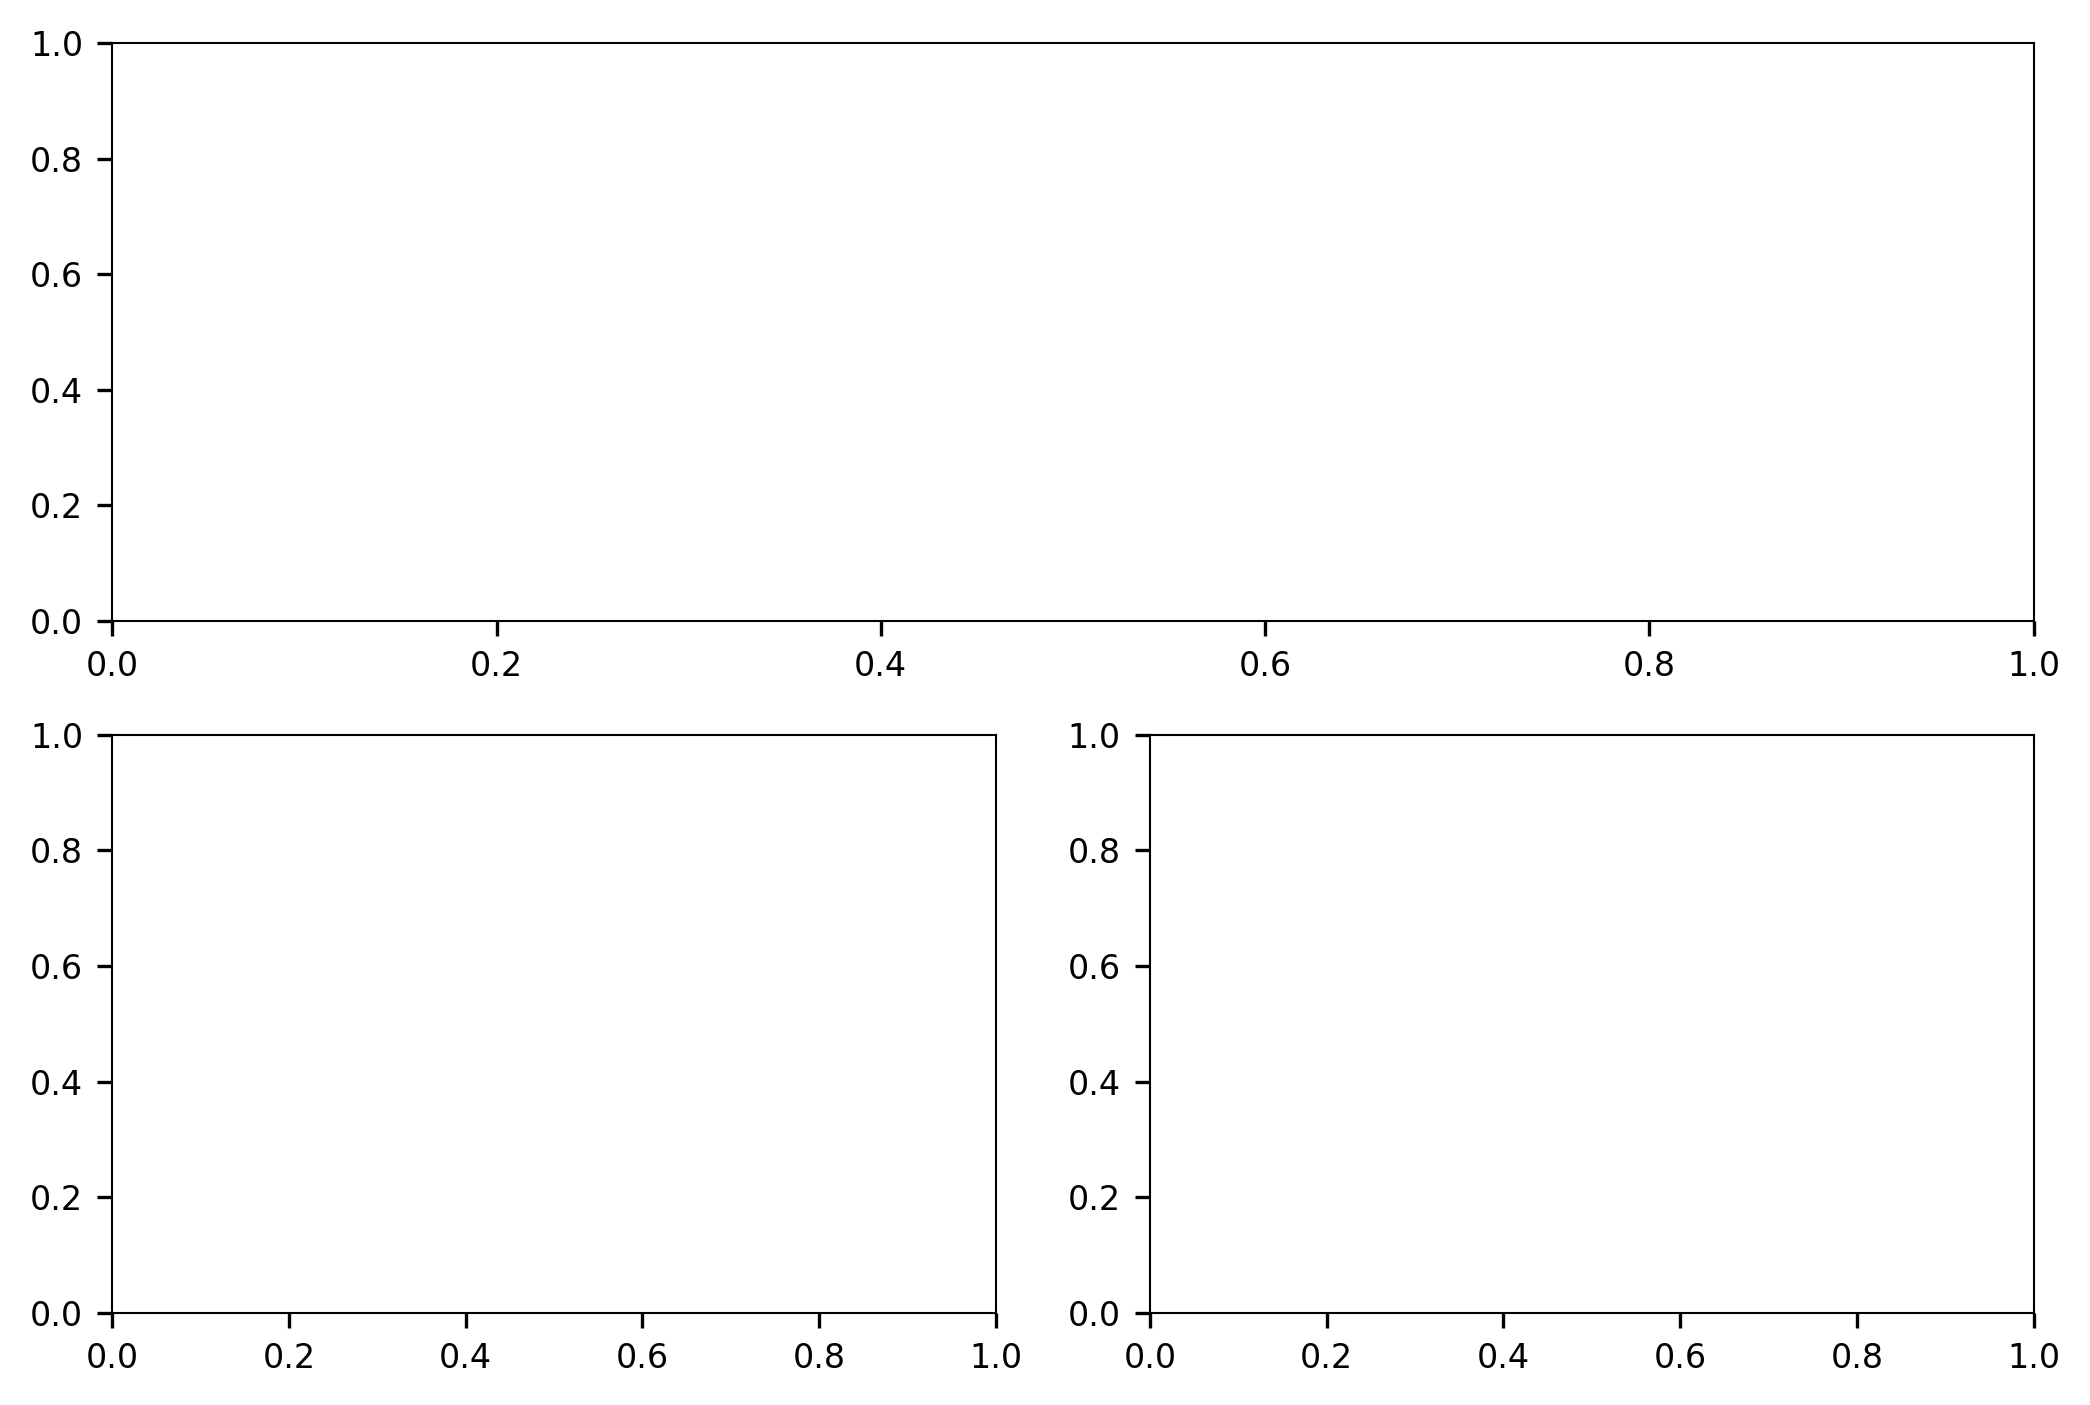

In [13]:
width = 174 / 25.4
height = 116 / 25.4
figx = plt.figure(constrained_layout=True, figsize=(width, height))
gs = figx.add_gridspec(2, 2)
f_ax1 = figx.add_subplot(gs[0, 0:])
#f_ax2 = figx.add_subplot(gs[0, 1])
f_ax3 = figx.add_subplot(gs[1, 0])
f_ax4 = figx.add_subplot(gs[1, 1])


In [14]:
# Plot the individual plots as DF suggested
color_arr = ['lightblue', 'coral', 'lightpink', 'lightgreen', 'deepskyblue', 'lightgreen', 'lightgreen', 'deepskyblue', 'deepskyblue']

"""Controls"""
f_ax1.scatter(xarr[1:3], total_ave_hl[1:3], marker='_', s=1000, c=['deepskyblue', 'deepskyblue'])
# Get the array of relative half-lives and add randomizer between 0 and 0.5
sample_hl_dict = {}
for sample, xpos, color in zip(sample_list[1:3], xarr[1:3], ['deepskyblue', 'deepskyblue']):
    
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    if 'W285T' in sample:
        sample_hl_dict['W285T'] = sample_hls
    if 'E283D' in sample:
        sample_hl_dict['E283D'] = sample_hls
    n = len(sample_hls)
    
    x_jitter_pos = np.array([xpos] * n)
    rand_arr = (np.random.rand(n) - 0.5) / 5 
    x_jitter_pos = x_jitter_pos + rand_arr
    
    f_ax1.scatter(x_jitter_pos, sample_hls, c=color)
    
f_ax1.set_xticks(xarr[1:3])
f_ax1.set_xticklabels(sample_list[1:3])
f_ax1.set_xlabel('Variant')
f_ax1.set_ylabel('Relative half-life')


f_ax1.scatter(xarr[3:5], total_ave_hl[3:5], marker='_', s=1000, c=color_arr[3:5])
for sample, xpos, color in zip(sample_list[3:5], xarr[3:5], color_arr[3:5]):
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    if 'F512P' in sample:
        sample_hl_dict['F512P'] = sample_hls
    if 'W285C' in sample:
        sample_hl_dict['W285C'] = sample_hls
    n = len(sample_hls)
    
    x_jitter_pos = np.array([xpos] * n)
    rand_arr = (np.random.rand(n) - 0.5) / 5 
    x_jitter_pos = x_jitter_pos + rand_arr
    
    f_ax1.scatter(x_jitter_pos, sample_hls, c=color)


"""Cross hotspot variants"""

f_ax1.scatter(xarr[3:5], total_ave_hl[3:5], marker='_', s=1000, c=color_arr[3:5])
for sample, xpos, color in zip(sample_list[3:5], xarr[3:5], color_arr[3:5]):
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    if 'F512P' in sample:
        sample_hl_dict['F512P'] = sample_hls
    if 'W285C' in sample:
        sample_hl_dict['W285C'] = sample_hls
    n = len(sample_hls)
    
    x_jitter_pos = np.array([xpos] * n)
    rand_arr = (np.random.rand(n) - 0.5) / 5 
    x_jitter_pos = x_jitter_pos + rand_arr
    
    f_ax1.scatter(x_jitter_pos, sample_hls, c=color)
    
f_ax1.set_xticks(xarr[1:5])
f_ax1.set_xticklabels(sample_list[1:5])


"""aF and b1b2"""
f_ax1.scatter(xarr[5:], total_ave_hl[5:], marker='_', s=1000, c=color_arr[5:])
for sample, xpos, color in zip(sample_list[5:], xarr[5:], color_arr[5:]):
    sample_idx = [sample in x for x in tl_df.index.tolist()]
    sample_hls = tl_df[sample_idx]['rel half life']
    if 'F512A' in sample:
        sample_hl_dict['F512A'] = sample_hls
    if 'E508F' in sample:
        sample_hl_dict['E508F'] = sample_hls
    if 'G287S' in sample:
        sample_hl_dict['G287S'] = sample_hls
    if 'E273T' in sample:
        sample_hl_dict['E273T'] = sample_hls
    n = len(sample_hls)
    
    x_jitter_pos = np.array([xpos] * n)
    rand_arr = (np.random.rand(n) - 0.5) / 5 
    x_jitter_pos = x_jitter_pos + rand_arr
    
    f_ax1.scatter(x_jitter_pos, sample_hls, c=color)

f_ax1.set_xticks(xarr[1:])
f_ax1.set_xticklabels(sample_list[1:])

# statistical annotation controls
t, p = scipy.stats.ttest_ind(sample_hl_dict['W285T'], sample_hl_dict['E283D'])
x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
ylow, ylim = f_ax1.get_ylim()
width = 0.02 * ylim
y, h, col = 1.7 + width * 2, width, 'k'
f_ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
f_ax1.text((x1+x2)*.5, y+h, f'p={p:.2}', ha='center', va='bottom', color=col)

# statistical annotation hotspot variants
t, p = scipy.stats.ttest_ind(sample_hl_dict['F512P'], sample_hl_dict['W285C'], nan_policy='omit')
x1, x2 = 3, 4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
width = 0.02 * ylim
y, h, col = 0.7 + width * 2, width, 'k'
f_ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
f_ax1.text((x1+x2)*.5, y+h, f'p={p:.2}', ha='center', va='bottom', color=col)

# statistical annotation
t, p = scipy.stats.ttest_ind(sample_hl_dict['G287S'], sample_hl_dict['E273T'], nan_policy='omit')
x1, x2 = 7, 8   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 2.9 + width * 2, width, 'k'
f_ax1.set_ylim(ylow, ylim + width * 7)
f_ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
f_ax1.text((x1+x2)*.5, y+h, f'p={p:.2}', ha='center', va='bottom', color=col)

# statistical annotation
t, p = scipy.stats.ttest_ind(sample_hl_dict['F512A'], sample_hl_dict['E508F'], nan_policy='omit')
x1, x2 = 5, 6   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 1.3 + width * 2, width, 'k'
f_ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
f_ax1.text((x1+x2)*.5, y+h, f'p={p:.2}', ha='center', va='bottom', color=col)

Text(5.5, 1.4756575051080132, 'p=0.035')

In [15]:
# Scatterplot for client score and global conformation
f_ax3.scatter(total_ave_hl, client_arr, color=['darkgrey', 'deepskyblue', 'deepskyblue'] + color_arr[3:])
size_arr = 20*(act_arr + (np.min(act_arr) + 2)).astype(float)**2
m, b, r, p, e = linregress(np.array(total_ave_hl).astype(float), client_arr.astype(float))
print(r)
x = np.array([np.min(total_ave_hl), np.max(total_ave_hl)])
y = m * x + b
f_ax3.plot(x, y, 'k')
for x, y, txt in zip(total_ave_hl, client_arr, norm_smpl_arr):
    f_ax3.text(x, y, txt)
f_ax3.set_xlabel('Relative half-life')
f_ax3.set_ylabel('Client score')

# Scatterplot for activity score and global conformation
f_ax4.scatter(total_ave_hl, act_arr, color=['darkgrey', 'deepskyblue', 'deepskyblue'] + color_arr[3:])
m, b, r, p, e = linregress(np.array(total_ave_hl).astype(float), act_arr.astype(float))
print(r)
x = np.array([np.min(total_ave_hl), np.max(total_ave_hl)])
y = m * x + b
f_ax4.plot(x, y, 'k')
for x, y, txt in zip(total_ave_hl, act_arr, norm_smpl_arr):
    if txt == 'F512P':
        y += 0.25
    f_ax4.text(x, y, txt)
f_ax4.set_xlabel('Relative half-life')
f_ax4.set_ylabel('Activity score')


legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label=r'$\alpha$' + 'F pocket'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='deepskyblue', markersize=10, label=r'$\beta$1$\beta$2 strands'),
                  ]
f_ax1.legend(handles=legend_elements, loc='best')

0.6760464359066656
-0.4553411025915156


In [16]:
for ax in [f_ax1, f_ax3, f_ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

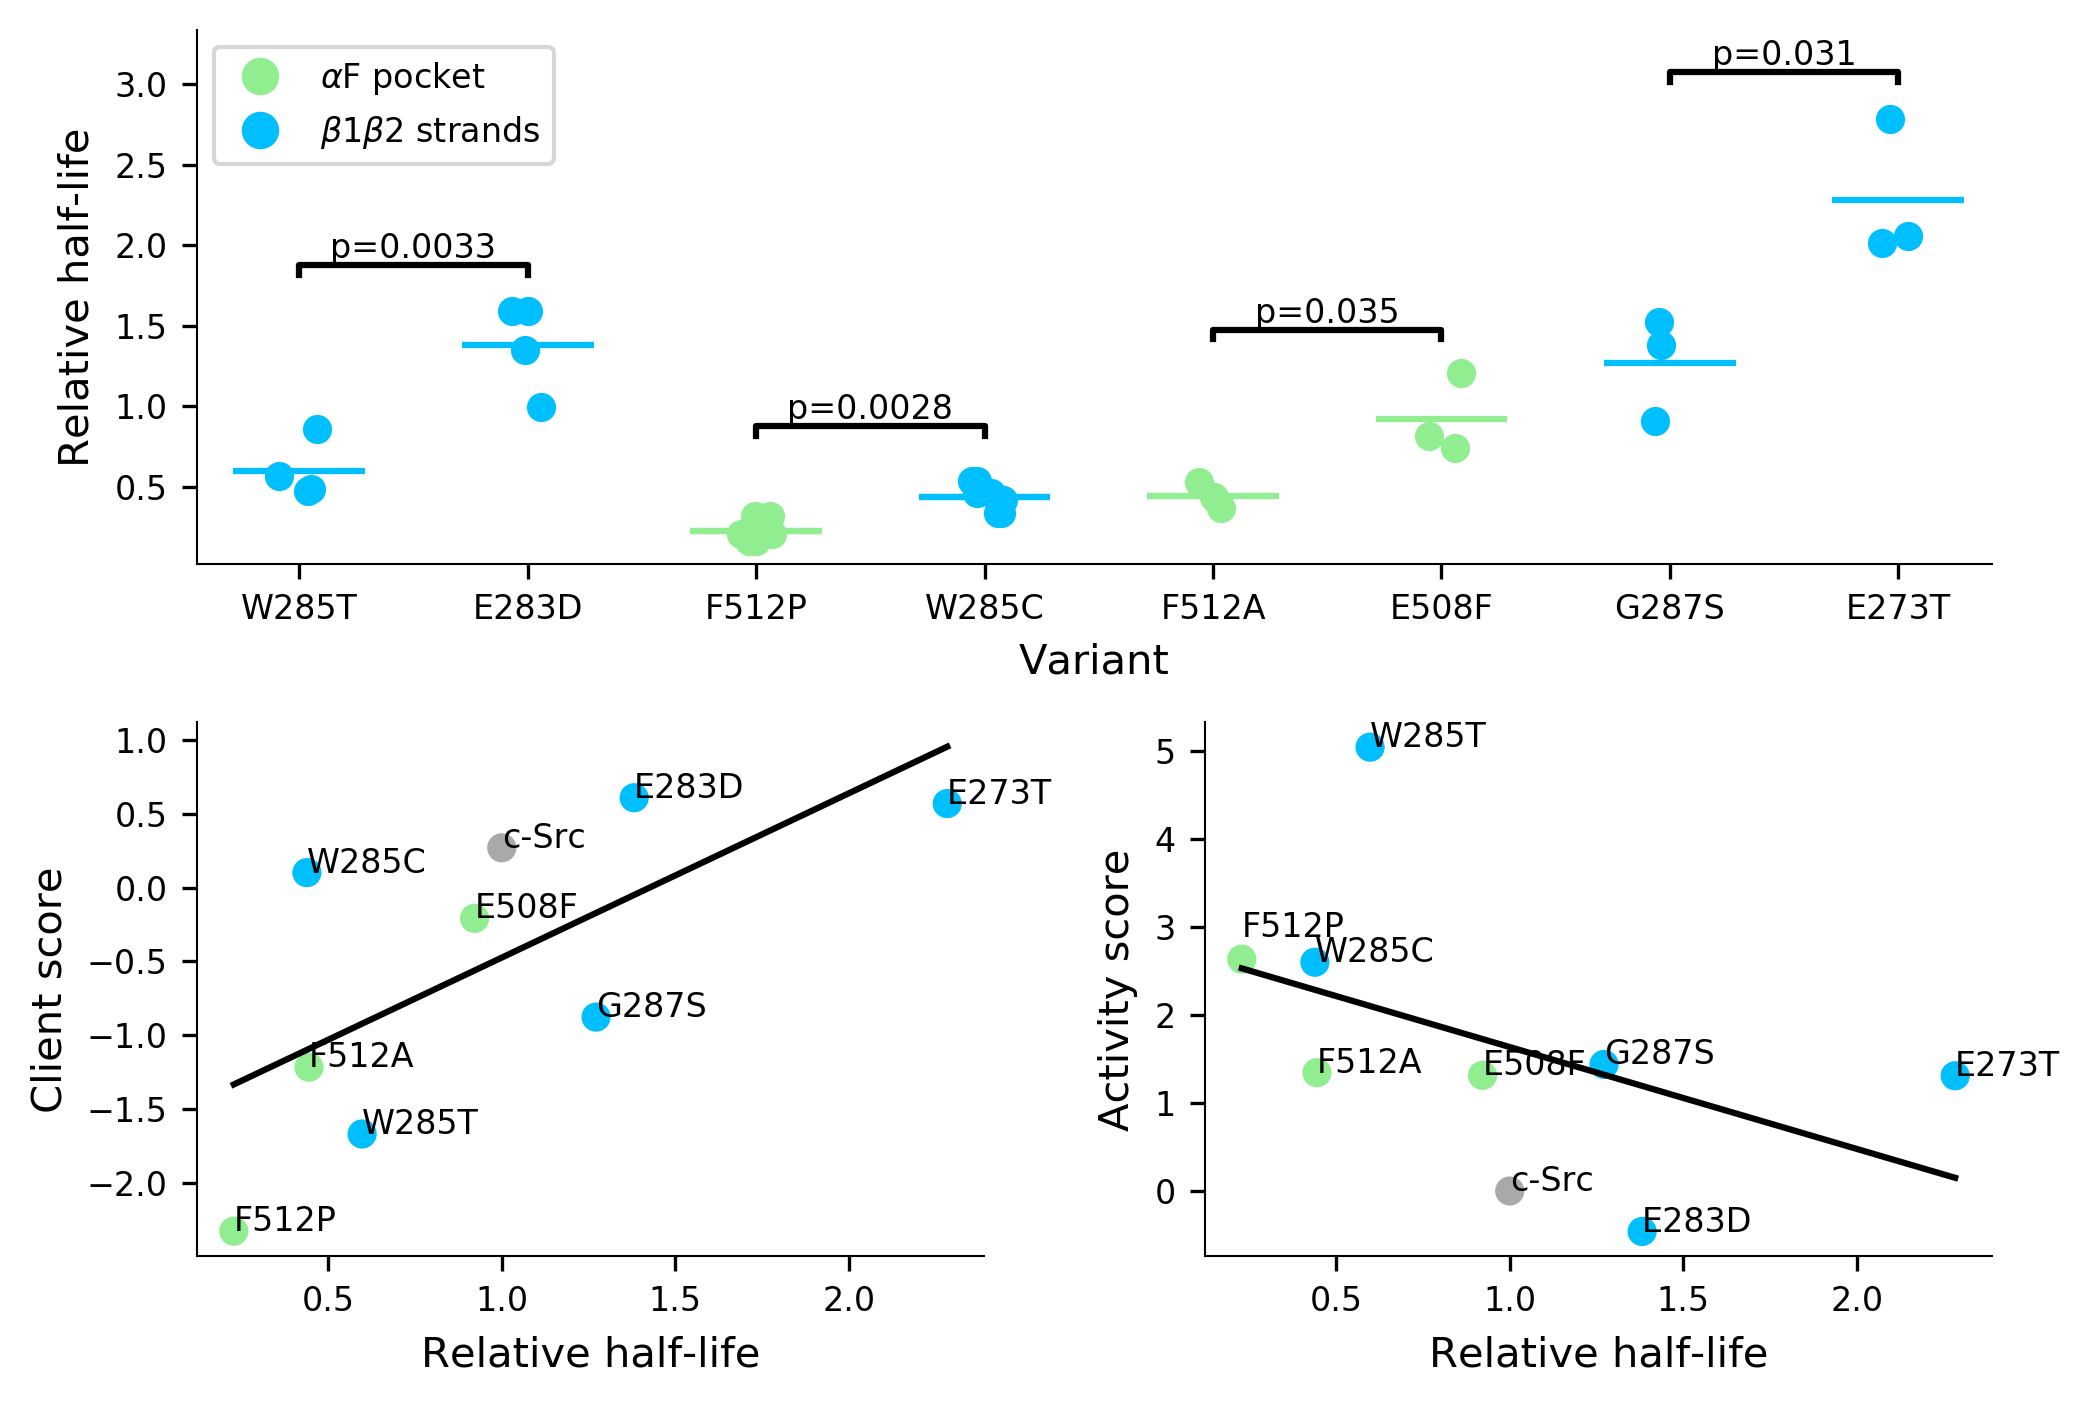

In [17]:
figx

In [18]:
figx.savefig('f6.png')

In [19]:
m, b, r, p, e = linregress(np.array(total_ave_hl).astype(float), client_arr.astype(float))
print(m)

1.1114156334427598
